In [17]:
from calendar import c
import importlib
import os
import sys

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tf_explain
from tf_explain.core.grad_cam import GradCAM
from tensorflow import keras

sys.path.append("../../")

## Functions useful for importing data:
from importingData import reduced_dataset
from importingData import import_images
from importingData import our_label_encoding
from importingData import tensorflow_format
from importingData import count_rows_csv
from importingData import count_rows_txt

## Directories for transfer learning model.
model_name = "AlexNet"
saved_model_path = "/data/dssg/occrp/data/weights/transfer_learning/AlexNet_2022_07_20-16_01_56_otherscat/weights"

## Directory for training data table.
training_table_path = "/data/dssg/occrp/data/train_validation_test/label_with_others"
training_table_name = "train.txt"

## Directory for aleph sample validating table.
validating_table_path = "/data/dssg/occrp/data/aleph-exploration/output_v2/documents_to_label/"
validating_table_name = "jose.csv"

## Directories for saving inputs/outputs of tf-explain.
save_input_images_path = "/data/dssg/occrp/data/tf_explain_visualizations/AlexNet_otherscat/input_tables"
save_output_images_path = "/data/dssg/occrp/data/tf_explain_visualizations/AlexNet_otherscat/output_images"

## Parameters involved in our model.
module_model_params = importlib.import_module("src.transfer_learning.transfer_" + model_name + "_model")
im_size = getattr(module_model_params, "im_size_" + model_name)
num_epochs = getattr(module_model_params, "num_epochs_" + model_name)
bigbatch_size = getattr(module_model_params, "bigbatch_size_" + model_name)
batch_size = getattr(module_model_params, "batch_size_" + model_name)
num_cpu = getattr(module_model_params, "num_cpu_" + model_name)
num_tempsave = getattr(module_model_params, "num_tempsave_" + model_name)
create_transfer_model = getattr(module_model_params, "create_transfer_model_" + model_name)
create_model = getattr(module_model_params, "create_model_" + model_name)

In [18]:
## Import the model with classes ("others","court docs","gazettes")
model = model = keras.models.Sequential(
    [
        keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation="relu", input_shape=(227, 227, 3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation="softmax"),
    ]
)
# model1.load_weights("/data/dssg/occrp/data/weights/featureSelection/AlexNet_2022_07_06-18_12_50/weights/temp")
# print(model1.summary())

# model = create_transfer_model("/data/dssg/occrp/data/weights/featureSelection/AlexNet_2022_07_06-18_12_50/weights/epoch7" ,
#                                labels_num = 3,
#                                verbose = False)
model.load_weights(os.path.join(saved_model_path, "epoch4"))
print(model.summary())

2022-07-26 11:38:42.299904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 11:38:42.301432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 11:38:42.310833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jsanchez/.local/share/virtualenvs/dssgxdfki2022-occrp-PA4e7Co-/lib64/python3.8/site-packages/cv2/../../lib64:
2022-07-26 11:38:42.310862: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [19]:
## Import training data names table.
training_names_full = pd.read_csv(
    os.path.join(training_table_path, training_table_name), delimiter=" ", names=["directory", "doc type"], dtype=str
)

## Import validating data names table.
validating_names_full = pd.read_csv(
    os.path.join(validating_table_path, validating_table_name),
    delimiter=",",
    dtype=str,
)
validating_names_full = validating_names_full.filter(["file_path", "label"], axis=1)

print("The dimensions of the training table is:", training_names_full.shape)
print("The dimensions of the validating table is:", validating_names_full.shape)

print("Training head:")
print(training_names_full[:5])
print("Validating head:")
print(validating_names_full[:5])

The dimensions of the training table is: (12360, 2)
The dimensions of the validating table is: (250, 2)
Training head:
                                                                                                                                              directory  \
0                           /data/dssg/occrp/data/processed/receipts/Bahamas_Receipts/50265258.7cbef042cce3a28f8c6c7f1f5c0abc8e92a48c2e-B145549_6/1.jpg   
1                             /data/dssg/occrp/data/processed/gazettes/Caymans Gazette/22237763.2ba279b862b24a340de7114cbccf834a56e4a398-22237763/1.jpg   
2                           /data/dssg/occrp/data/processed/receipts/Bahamas_Receipts/50262022.f55a0433b8b325d2a025fe6a243b56e63549ac7c-B145774_3/1.jpg   
3  /data/dssg/occrp/data/processed/company-registry/Bahamas companies registry (2018)/50137684.cb108ff49d2a1f60cfcb9e0944310ba300ab0836-B174501_1/1.jpg   
4                           /data/dssg/occrp/data/processed/receipts/Bahamas_Receipts/49944066.2b551e7ef71

In [20]:
## Importing labels:
labels_code = pd.read_csv(
    os.path.join(training_table_path, "labels.csv"),
    delimiter=",",
)
print("Encoded labels table:")
print(labels_code)

Encoded labels table:
             label  index
0            other      0
1  court-documents      1
2         gazettes      2


In [21]:
## Select 5 images of each class:
validating_names_full.rename(columns={"file_path": "directory", "label": "doc type"}, inplace=True)

validating_names_courtdocs = validating_names_full[validating_names_full["doc type"] == "court document"]
print("Number of court documents in our validating sample: ", validating_names_courtdocs.shape[0])
validating_names_gazette = validating_names_full[validating_names_full["doc type"] == "gazette"]
print("Number of gazettes in our validating sample: ", validating_names_gazette.shape[0])

validating_names_courtdocs_red = validating_names_courtdocs[:6]
validating_names_gazette_red = validating_names_gazette[:6]

print("We choose ", validating_names_courtdocs_red.shape[0], " court documents from our validating sample.")
print("We choose ", validating_names_gazette_red.shape[0], " gazettes from our validating sample. ")

Number of court documents in our validating sample:  7
Number of gazettes in our validating sample:  30
We choose  6  court documents from our validating sample.
We choose  6  gazettes from our validating sample. 


In [22]:
pd.options.display.max_colwidth = 200
display(validating_names_gazette)

,directory,doc type
139,/data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/2533088.585d0bd4291ab027959e6412712377b2d8b465b4.pdf,gazette
140,/data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/2542057.02fd5315fc8df894065505321717c184cbedd9a2.pdf,gazette
141,/data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/2542058.6eeb4289e19a2e165710d7c61bec6cd30c1369e0.pdf,gazette
142,/data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/2542064.a19ab894ddb0f5e6cb11e5e2d47bf417c5389463.pdf,gazette
160,/data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/3378610.61b39a0d2205b3d8c6b283411f48691417f54abb.pdf,gazette
162,/data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/4144240.896422d53e297ed401b48af1f1680cdba0390952.pdf,gazette
163,/data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/4146811.2b31bac1be11e7c6a2c00b01d028f71231f0c577.pdf,gazette
205,/data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/4683154.d6379004df6408150a5779dad9b88a3c654ca381.pdf,gazette
206,/data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/4683335.bafddc36713760d800db062fb403e711b3ff6d0a.pdf,gazette
214,/data/dssg/occrp/data/aleph-exploration/output_v2/documents_sample/5383344.c4c9851339460aa7aae4c464542d2063dcf8be4f.pdf,gazette


In [23]:
## Select 5 images of each class:
training_names_courtdocs = training_names_full[training_names_full["doc type"] == "1"]
print("Number of court documents in our training sample: ", training_names_courtdocs.shape[0])
training_names_gazette = training_names_full[training_names_full["doc type"] == "2"]
print("Number of gazettes in our training sample: ", training_names_gazette.shape[0])

training_names_courtdocs_red = training_names_courtdocs[:6]
training_names_gazette_red = training_names_gazette[:6]

print("We choose ", training_names_courtdocs_red.shape[0], " court documents from our training sample.")
print("We choose ", training_names_gazette_red.shape[0], " gazettes from our training sample. ")

Number of court documents in our training sample:  1563
Number of gazettes in our training sample:  3163
We choose  6  court documents from our training sample.
We choose  6  gazettes from our training sample. 


In [24]:
## Reseting index:
training_names_courtdocs_red = training_names_courtdocs_red.reset_index()
training_names_gazette_red = training_names_gazette_red.reset_index()
validating_names_courtdocs_red = validating_names_courtdocs_red.reset_index()
validating_names_gazette_red = validating_names_gazette_red.reset_index()

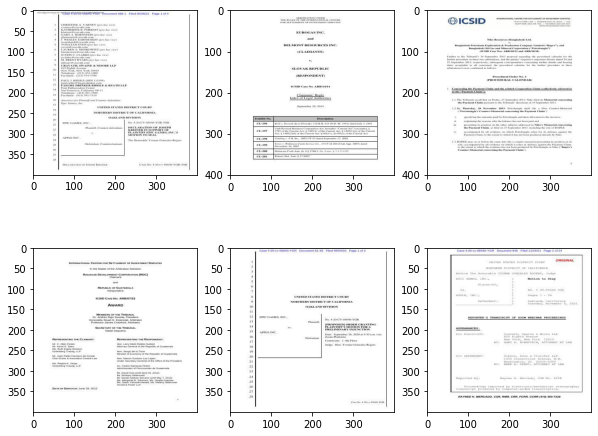

In [25]:
figure, axis = plt.subplots(2, 3)

for index in range(6):
    img = mpimg.imread(training_names_courtdocs_red["directory"][index])
    cv2.imwrite(os.path.join(save_output_images_path, "train_court" + str(index) + ".png"), img)

    x_ = index % 2
    y_ = index % 3

    axis[x_, y_].imshow(img)

figure.set_figwidth(10)
figure.set_figheight(8)

# Combine all the operations and display
plt.show()

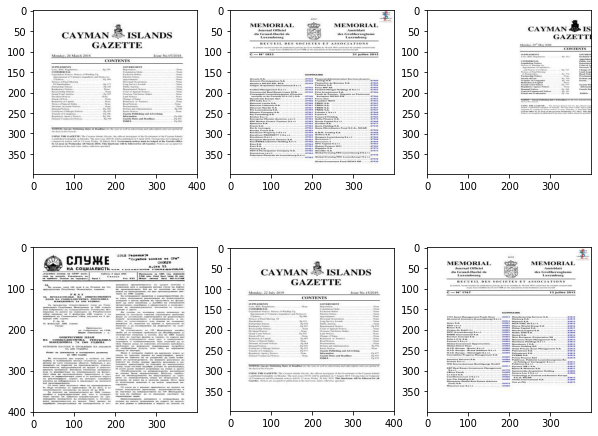

In [26]:
figure, axis = plt.subplots(2, 3)

for index in range(6):
    img = mpimg.imread(training_names_gazette_red["directory"][index])
    cv2.imwrite(os.path.join(save_output_images_path, "train_gazette" + str(index) + ".png"), img)

    x_ = index % 2
    y_ = index % 3

    axis[x_, y_].imshow(img)

figure.set_figwidth(10)
figure.set_figheight(8)

# Combine all the operations and display
plt.show()

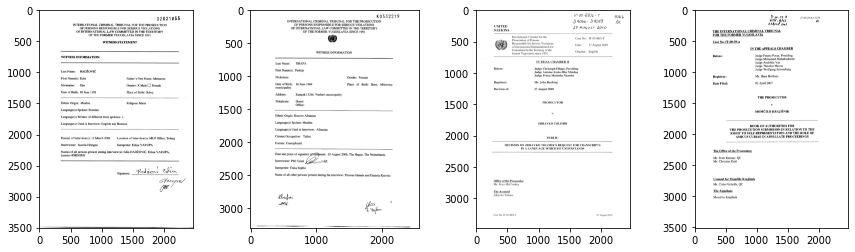

In [27]:
figure, axis = plt.subplots(1, 4)

for index in range(4):
    img = mpimg.imread(validating_names_courtdocs_red["directory"][index])
    cv2.imwrite(os.path.join(save_output_images_path, "val_court" + str(index) + ".png"), img)
    x_ = index % 2
    y_ = index % 2

    axis[index].imshow(img)

figure.set_figwidth(15)
figure.set_figheight(4)

# Combine all the operations and display
plt.show()

# imgplot = plt.imshow(img)

In [28]:
## Saving these tables for future reference:
training_names_courtdocs_red.to_csv(os.path.join(save_input_images_path, "training_courtdocs.csv"), sep=",")
training_names_gazette_red.to_csv(os.path.join(save_input_images_path, "training_gazettes.csv"), sep=",")
validating_names_courtdocs_red.to_csv(os.path.join(save_input_images_path, "validating_courtdocs.csv"), sep=",")
validating_names_gazette_red.to_csv(os.path.join(save_input_images_path, "validating_gazettes.csv"), sep=",")

In [333]:
train_court_images, train_court_labels, faulty = import_images(
    images_dir="", names=training_names_courtdocs_red, im_size=im_size, verbose=False
)
train_gazette_images, train_gazette_labels, faulty = import_images(
    images_dir="", names=training_names_gazette_red, im_size=im_size, verbose=False
)

val_court_images, val_court_labels, faulty = import_images(
    images_dir="", names=validating_names_courtdocs_red, im_size=im_size, verbose=False
)
# val_gazette, labels, faulty = import_images(images_dir = "", names = validating_names_gazette_red, im_size = im_size, verbose=False)

print(train_court_images.shape)
print(train_gazette_images.shape)
print(val_court_images.shape)
# print(val_gazette.shape)

(6, 227, 227, 3)
(6, 227, 227, 3)
(4, 227, 227, 3)


In [334]:
train_court_labels = [int(x) for x in train_court_labels]
train_court_labels = np.array(train_court_labels)
train_court_labels = train_court_labels.reshape(-1, 1)

train_gazette_labels = [int(x) for x in train_gazette_labels]
train_gazette_labels = np.array(train_gazette_labels)
train_gazette_labels = train_gazette_labels.reshape(-1, 1)

val_court_labels = [1, 1, 1, 1]
val_court_labels = np.array(val_court_labels)
val_court_labels = val_court_labels.reshape(-1, 1)

In [335]:
train_court_ds = tensorflow_format(train_court_images, train_court_labels, 5)
train_gazette_ds = tensorflow_format(train_gazette_images, train_gazette_labels, 5)
val_court_ds = tensorflow_format(val_court_images, val_court_labels, 4)

train_court_images_normalized = tf.image.per_image_standardization(train_court_images)
train_gazette_images_normalized = tf.image.per_image_standardization(train_gazette_images)
val_court_images_normalized = tf.image.per_image_standardization(val_court_images)

train_court_images_normalized = np.array(train_court_images_normalized)
train_gazette_images_normalized = np.array(train_gazette_images_normalized)
val_court_images_normalized = np.array(val_court_images_normalized)


# train_court_images_normalized = tf.data.Dataset.from_tensor_slices(train_court_images_normalized)

In [337]:
for index in range(6):
    # Instantiation of the explainer
    explainer = GradCAM()

    # Call to explain() method
    explain_train_court = explainer.explain(
        validation_data=(train_court_images_normalized[[index], ...], train_court_labels[[index]]),
        model=model,
        class_index=1,
        layer_name="conv2d_169",
    )
    # Save output
    explainer.save(
        explain_train_court, output_dir=save_output_images_path, output_name="explain_train_court" + str(index) + ".png"
    )

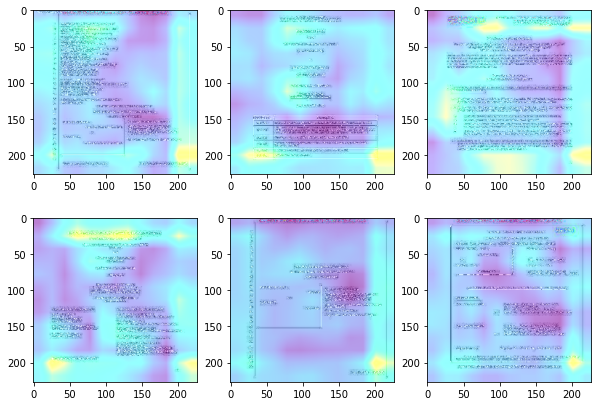

In [339]:
figure, axis = plt.subplots(2, 3)

for index in range(6):
    img = mpimg.imread(os.path.join(save_output_images_path, "explain_train_court" + str(index) + ".png"))
    x_ = index % 2
    y_ = index % 3

    axis[x_, y_].imshow(img)


figure.set_figwidth(10)
figure.set_figheight(7)

# Combine all the operations and display
plt.show()

# imgplot = plt.imshow(img)

In [341]:
for index in range(6):
    # Instantiation of the explainer
    explainer = GradCAM()

    # Call to explain() method
    explain_train_court = explainer.explain(
        validation_data=(train_gazette_images_normalized[[index], ...], train_gazette_labels[[index]]),
        model=model,
        class_index=2,
        layer_name="conv2d_169",
    )
    # Save output
    explainer.save(
        explain_train_court, output_dir=save_output_images_path, output_name="explain_train_gazette" + str(index) + ".png"
    )

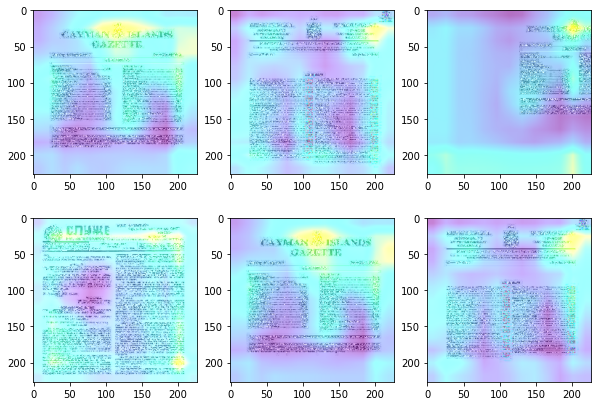

In [342]:
figure, axis = plt.subplots(2, 3)

for index in range(6):
    img = mpimg.imread(os.path.join(save_output_images_path, "explain_train_gazette" + str(index) + ".png"))
    x_ = index % 2
    y_ = index % 3

    axis[x_, y_].imshow(img)

figure.set_figwidth(10)
figure.set_figheight(7)

# Combine all the operations and display
plt.show()

# imgplot = plt.imshow(img)

In [344]:
for index in range(4):
    # Instantiation of the explainer
    explainer = GradCAM()

    # Call to explain() method
    explain_train_court = explainer.explain(
        validation_data=(val_court_images_normalized[[index], ...], val_court_labels[[index]]),
        model=model,
        class_index=2,
        layer_name="conv2d_169",
    )
    # Save output
    explainer.save(
        explain_train_court, output_dir=save_output_images_path, output_name="explain_val_court" + str(index) + ".png"
    )

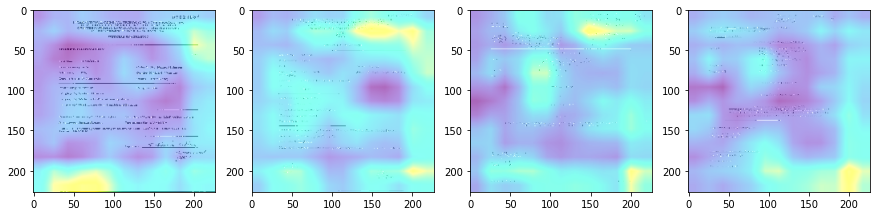

In [345]:
figure, axis = plt.subplots(1, 4)

for index in range(4):
    img = mpimg.imread(os.path.join(save_output_images_path, "explain_val_court" + str(index) + ".png"))
    axis[index].imshow(img)


figure.set_figwidth(15)
figure.set_figheight(4)

# Combine all the operations and display
plt.show()

# imgplot = plt.imshow(img)